In [ ]:
pip install torchshow

  Obtaining dependency information for torchshow from https://files.pythonhosted.org/packages/63/8d/bd603d1ffad76cd1aa0dc7313e5cc3f5d1adda274c8568d614f421fabe1a/torchshow-0.5.1-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


### Exceptions

In [ ]:
"""Custom exceptions module."""
from abc import ABC, abstractmethod


class IncorrectMode(ABC, Exception):
    """Abstract class of exception for incorrect mode."""

    @abstractmethod
    def __init__(self, msg: str) -> None:
        """Initialize abstract exception.

        Args:
            msg (str): exception message.
        """
        super().__init__(msg)


### Визуализация обучения

In [ ]:
"""A module that visualizes graphs and predicted values."""
from typing import Any

import numpy as np
import torchshow as ts
from matplotlib import pyplot as plt
from torch import Tensor, no_grad, stack, argmax


def plot_loss(loss: list[float], title: str, num_epochs: int) -> None:
    """Draw a loss graphic.

    Args:
        loss (list[float]): the history of the loss of the model.
        title (str): name of the graphic.
        num_epochs (int): the number of past epochs.
    """
    plt.title(title)
    plt.plot(loss)
    plt.grid()
    plt.xticks(np.arange(num_epochs))


def show_losses(train_hist: list[float], val_hist: list[float], num_epochs: int) -> None:
    """Plot test and validation loss charts.

    Args:
        train_hist (list[float]): the history of the training loss.
        val_hist (list[float]): the history of the validation loss.
        num_epochs (int): the number of past epochs.
    """
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plot_loss(train_hist, f'Train Loss = {train_hist[-1]}', num_epochs)
    plt.subplot(1, 2, 2)
    plot_loss(val_hist, f'Val Loss = {val_hist[-1]}', num_epochs)
    plt.show()


def show_images(
    model: Any,
    targets: tuple[list[Tensor], list[int | Tensor]],
    device: Any,
    mode: str,
    num_of_examples: int = 4,
) -> None:
    """Output the original images and predicted by the model.

    Args:
        model (Any): the trained model.
        targets (tuple[list[Tensor], list[int | Tensor]]): validation dataset.
        device (Any): the device on which the model is trained.
        mode (str): image output mode ('classification', 'segmentation').
        num_of_examples (int): number of output images. By default 4.
    """
    __classes = {
        0: 'Normal',
        1: 'Infection',
        2: 'COVID-19',
    }
    model.eval()
    with no_grad():
        idxs = np.random.randint(0, len(targets), num_of_examples)

        if mode == 'segmentation':
            images, true_ans = [], []
            for id in idxs:
                images.append(targets[id][0])
                true_ans.append(targets[id][1])

            images = stack(images).to(device)
            true_ans = stack(true_ans).to(device)

            pred = model(images)
            ts.show(true_ans, nrows=1, figsize=(12, 2))
            ts.show(pred, nrows=1, figsize=(12, 2))
        else:
            for ind, id in enumerate(idxs):
                img, true_ans = targets[id]
                pred = argmax(model(true_ans.to(device)))
                plt.subplot(1, num_of_examples, ind + 1)
                plt.imshow(img.permute(1, 2, 0), cmap='gray')
                plt.xticks([])
                plt.yticks([])
                plt.title(f'True = {__classes[true_ans]}\nPred = {__classes[pred]}', fontsize=12)
            plt.show()


### Кастомный датасет

In [ ]:
"""Custom Lung Dataset."""
import os
from typing import Any

import dotenv
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

dotenv.load_dotenv()

TEST_IMAGES_FOLDER = 'test_images'
TRAIN_IMAGES_FOLDER = 'train_images'
TRAIN_LUNG_MASKS_FOLDER = 'train_lung_masks'
LABEL_FILE = 'train_answers.csv'


class IncorrectDatasetMode(IncorrectMode):
    """Exception of incorrect dataset mode."""

    def __init__(self, possible_modes: list[str]) -> None:
        """Possible operating modes of the dataset.

        Args:
            possible_modes (list[str]): list of modes that the dataset supports.
        """
        super().__init__(f'Dataset mode should be one of the list: {possible_modes}')


class CustomLungDataset(Dataset):
    """Custom lung dataset."""

    _possible_modes = 'classification', 'segmentation', 'test'

    def __init__(self, root_dir: str, mode: str, transforms: Any | None = None) -> None:
        """Initialize the dataset.

        Root directory with dataset folders and files,
        mode of using the dataset ('classification', 'segmentation', 'test'),
        dataset transformation.

        Args:
            root_dir (str): directory with dataset folders and files.
            mode (str): classififcation (use to train a lung classifier),\
                segmentation (use for lung mask segmentation training),\
                test (use to predict the final answer).
            transforms (optional): dataset transforms. Defaults to None.
        """
        super().__init__()
        self.root_dir = root_dir
        self.mode = mode
        self.transforms = transforms

        # path to test images
        self._path_test_images = os.path.join(self.root_dir, TEST_IMAGES_FOLDER)

        # path to train images
        self._path_train_images = os.path.join(self.root_dir, TRAIN_IMAGES_FOLDER)

        # path to train lung masks
        self._path_train_lung_masks = os.path.join(
            self.root_dir, TRAIN_LUNG_MASKS_FOLDER,
        )

        # path to labels on train images
        self._path_labels = os.path.join(self.root_dir, LABEL_FILE)

    @property
    def mode(self) -> str:
        """A mode of dataset.

        Returns:
            str: dataset mode.
        """
        return self._mode

    @mode.setter
    def mode(self, new_mode: str) -> None:
        """Set a new dataset mode.

        Args:
            new_mode (str): dataset mode (classification, segmentation, test).

        Raises:
            IncorrectDatasetMode: the dataset's operating mode should be one of the possible.
        """
        if new_mode not in self._possible_modes:
            raise IncorrectDatasetMode(self._possible_modes)
        self._mode = new_mode

    def __len__(self) -> int:
        """Get dataset length.

        Returns:
            int: length of dataset depending on mode.
        """
        if self.mode in {'classification', 'segmentation'}:
            return len(os.listdir(self._path_train_images))
        return len(os.listdir(self._path_test_images))

    def __getitem__(self, idx: int) -> tuple[np.ndarray, int | np.ndarray] | np.ndarray:
        """Get a dataset element by index.

        Args:
            idx (int): dataset element index.

        Raises:
            IndexError: index is greater than the dataset length.

        Returns:
            tuple[np.ndarray, int | np.ndarray]: image and answer.
        """
        dataset_len = self.__len__()
        if idx > dataset_len:
            raise IndexError(f'index {idx} should be less than {dataset_len}')

        img_name = f'img_{idx}.png'

        if self.mode == 'classification':
            img = Image.open(os.path.join(self._path_train_images, img_name))
            mask = Image.open(os.path.join(self._path_train_lung_masks, img_name))
            img = Image.composite(img, mask, mask=mask)
            label = pd.read_csv(self._path_labels).iloc[idx, 1]

            if self.transforms:
                img = self.transforms(img)

            # img + mask, label
            return (img, label)

        elif self.mode == 'segmentation':
            img = Image.open(os.path.join(self._path_train_images, img_name))
            mask = Image.open(os.path.join(self._path_train_lung_masks, img_name))

            if self.transforms:
                img = self.transforms(img)
                mask = self.transforms(mask)

            # img, mask
            return (img, mask)

        img = Image.open(os.path.join(self._path_test_images, img_name))
        if self.transforms:
            img = self.transforms(img)

        # img
        return img


### Дополнительные блоки Unet

In [ ]:
"""Parts of the Unet model."""
import numpy as np
from torch import cat, nn


class DoubleConv(nn.Module):
    """(Conv2d -> BatchNorm -> ReLU) * 2."""

    def __init__(self, in_channels: int, out_channels: int) -> None:
        """Initialize double counvolutional layers.

        Args:
            in_channels (int): number of input channels.
            out_channels (int): number of output channels.
        """
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x_in: np.ndarray) -> np.ndarray:
        """Forward pass through the model.

        Args:
            x_in (np.ndarray): the input tensor.

        Returns:
            np.ndarray: the output tensor of the model.
        """
        return self.double_conv(x_in)


class Down(nn.Module):
    """Downscaling with maxpool then DoubleConv."""

    def __init__(self, in_channels: int, out_channels: int) -> None:
        """Initialize Downscaling layer that is based on the MaxPool2d.

        Args:
            in_channels (int): number of input channels.
            out_channels (int): number of output channels.
        """
        super().__init__()
        self.maxpool = nn.MaxPool2d(2)
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, x_in: np.ndarray) -> np.ndarray:
        """Forward pass through the model.

        Args:
            x_in (np.ndarray): the input tensor.

        Returns:
            np.ndarray: the output tensor of the model.
        """
        return self.double_conv(self.maxpool(x_in))


class Up(nn.Module):
    """Upscaling then double DoubleConv."""

    def __init__(self, in_channels: int, out_channels: int) -> None:
        """Initialize Upscaling layer that is based on the Upsample.

        Args:
            in_channels (int): number of input channels.
            out_channels (int): number of output channels.
        """
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1: np.ndarray, x2: np.ndarray) -> np.ndarray:
        """Forward pass through the model.

        Args:
            x1 (np.ndarray): the input tensor of the previous layer.
            x2 (np.ndarray): the input tensor of the symmetric layer.

        Returns:
            np.ndarray: the output tensor of the model.
        """
        x1 = self.upsample(x1)
        # the difference between the sizes in layers
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        # add additional paddings
        x1 = nn.functional.pad(
            x1, [diff_x // 2, diff_x - diff_x // 2, diff_y // 2, diff_y - diff_y // 2],
        )

        # combining two layers
        x_out = cat([x2, x1], dim=1)
        return self.double_conv(x_out)


### Кастомный Unet

In [ ]:
"""Custom implementation of the "Unet" architecture."""
import numpy as np
from torch import nn


class Unet(nn.Module):
    """Custom Unet architecture."""

    __scales = 64, 128, 256, 512, 1024

    def __init__(self, n_channels: np.ndarray, n_classes: np.ndarray) -> None:
        """Initialize the model with the specified input channels.

        Args:
            n_channels (int): number of image channels.
            n_classes (int): number of output classes.
        """
        super().__init__()
        self._inc = DoubleConv(n_channels, self.__scales[0])

        self._down1 = Down(self.__scales[0], self.__scales[1])
        self._down2 = Down(self.__scales[1], self.__scales[2])
        self._down3 = Down(self.__scales[2], self.__scales[3])
        self._down4 = Down(self.__scales[3], self.__scales[4] // 2)

        self._up1 = Up(self.__scales[4], self.__scales[3] // 2)
        self._up2 = Up(self.__scales[3], self.__scales[2] // 2)
        self._up3 = Up(self.__scales[2], self.__scales[1] // 2)
        self._up4 = Up(self.__scales[1], self.__scales[0])

        self._outc = nn.Conv2d(self.__scales[0], n_classes, 1)

    def forward(self, x_in: np.ndarray) -> np.ndarray:
        """Forward pass through the model.

        Args:
            x_in (np.ndarray): the input tensor.

        Returns:
            np.ndarray: the output tensor of the model.
        """
        x1 = self._inc(x_in)

        x2 = self._down1(x1)
        x3 = self._down2(x2)
        x4 = self._down3(x3)
        x5 = self._down4(x4)

        x_in = self._up1(x5, x4)
        x_in = self._up2(x_in, x3)
        x_in = self._up3(x_in, x2)
        x_in = self._up4(x_in, x1)

        return self._outc(x_in)


### Модуль для рассчета DiceLoss

In [ ]:
"""A module for calculating dice loss."""
from torch import Tensor, where


def dice_coeff(
    pred: Tensor,
    target: Tensor,
    epsilon: float = 1e-6,
) -> float:
    """Calcuate dice coefficient.

    The formula for finding DiceLoss:
    DL = 1 - (2 * pred * target + eps) / (target + pred + eps).

    Args:
        pred (Tensor): predicted value.
        target (Tensor): target value.
        epsilon (float): deviation hyperparameter. By default, 1e-6.

    Returns:
        float: DiceLoss.
    """
    sum_dim = (-1, -2, -3)

    inter = 2 * (pred * target).sum(dim=sum_dim)
    sets_sum = pred.sum(dim=sum_dim) + target.sum(dim=sum_dim)

    # getting rid of division by zero
    sets_sum = where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return 1 - dice.mean()


### Модуль для обучения моделей

In [ ]:
"""Module for training models."""
import os
from typing import Any

import copy
from IPython.display import clear_output
from torch.utils.data import random_split, DataLoader
from torch import nn, set_grad_enabled, device, cuda, save
from tqdm import tqdm

PATH_TO_SAVE = '/kaggle/working/checkpoint'


class IncorrectTrainerMode(IncorrectMode):
    """Incorrect model training mode exception."""

    def __init__(self, mode: str, possible_modes: tuple[str]) -> None:
        """Initialize incorrect model training mode exception.

        Args:
            mode (str): wrong mode.
            possible_modes (tuple[str]): acceptable model training modes.
        """
        super().__init__(f'mode {mode} not in {possible_modes}')


class Trainer:
    """Training different models."""

    __possible_modes = 'classification', 'segmentation'
    _device = device('cuda' if cuda.is_available() else 'cpu')

    def __init__(
        self,
        dataset: Any,
        model: Any,
        optimizer: Any,
        criterion: Any,
        mode: str,
    ) -> None:
        """Initialize the characteristics for training the model.

        Args:
            dataset (Any): dataset for training.
            model (Any): a model for training.
            optimizer (Any): a function that adjusts the attributes of the neural network.
            criterion (Any): a loss function.
            mode (str): possible training modes ('classification', 'segmentation')
        """
        self.dataset = dataset
        self.model = model.to(self._device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.mode = mode

    @property
    def mode(self) -> str:
        """Training mode.

        Returns:
            str: the mode in which to train the model.
        """
        return self._mode

    @mode.setter
    def mode(self, new_mode: str) -> None:
        """Set a new training mode.

        Args:
            new_mode (str): new training mode ('classification', 'segmentation').

        Raises:
            IncorrectTrainerMode: incorrect model training mode ('classification', 'segmentation').
        """
        if new_mode not in self.__possible_modes:
            raise IncorrectTrainerMode(new_mode, self.__possible_modes)
        self._mode = new_mode

    def save_model(self, epoch: int, best_loss: float) -> None:
        """Save the state of the model.

        Args:
            epoch (int): the current epoch of training.
            best_loss (float): the best loss value to save.
        """
        best_model_wts = copy.deepcopy(self.model.state_dict())

        data = {
            'epoch': epoch,
            'model_state_dict': best_model_wts,
            'optimizer_state_dict': self.optimizer.state_dict(),
            'best_loss': best_loss,
        }

        if not os.path.exists(PATH_TO_SAVE):
            os.mkdir(PATH_TO_SAVE)

        save(data, os.path.join(PATH_TO_SAVE, f'best_checkpoint[epoch_{epoch}].pt'))

    def run_epoch(self, dataloader: Any, is_train: bool = True) -> float:
        """Start training on a single epoch.

        Args:
            dataloader (Any): training data.
            is_train (bool): model mode. By default, True.

        Returns:
            float: loss on the epoch.
        """
        self.model.train(is_train)
        total_loss = 0.
        with set_grad_enabled(is_train):
            for images, true_ans in tqdm(dataloader):
                images = images.to(self._device)
                true_ans = true_ans.to(self._device).float()

                pred = self.model(images)
                loss = self.criterion(pred, true_ans)
                if self.mode == 'segmentation':
                    loss += dice_coeff(nn.functional.sigmoid(pred), true_ans)

                if is_train:
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                total_loss += loss.item()

        return total_loss / len(dataloader.dataset)

    def run_train_loop(self, epochs: int, batch_size: int) -> None:
        """Start the full training loop of the model.

        Args:
            epochs (int): number of epochs in training.
            batch_size (int): sample size.
        """
        train_set, val_set = random_split(self.dataset, [0.8, 0.2])

        train_loader = DataLoader(train_set, batch_size)
        val_loader = DataLoader(val_set, batch_size)

        train_hist = []
        val_hist = []

        best_loss = 1e6

        for epoch in range(1, epochs + 1):
            train_loss = self.run_epoch(train_loader)
            train_hist.append(train_loss)

            val_loss = self.run_epoch(val_loader, is_train=False)
            val_hist.append(val_loss)

            if PATH_TO_SAVE != '' and val_loss < best_loss:
                best_loss = val_loss
                self.save_model(epoch, best_loss)

            clear_output()
            show_images(self.model, val_loader.dataset, self._device, self.mode)
            show_losses(train_hist, val_hist, epoch)


### Запуск обучения

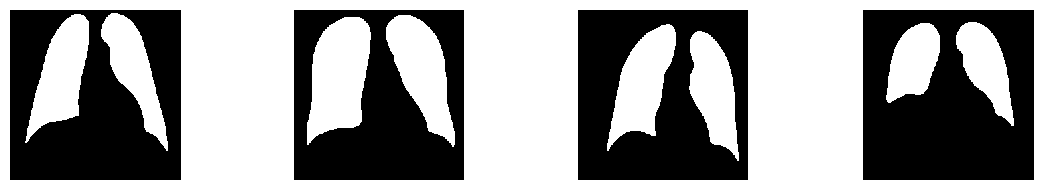

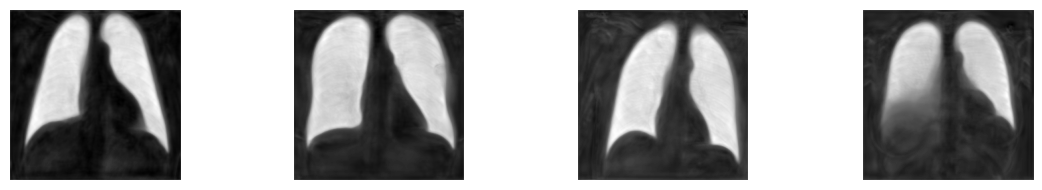

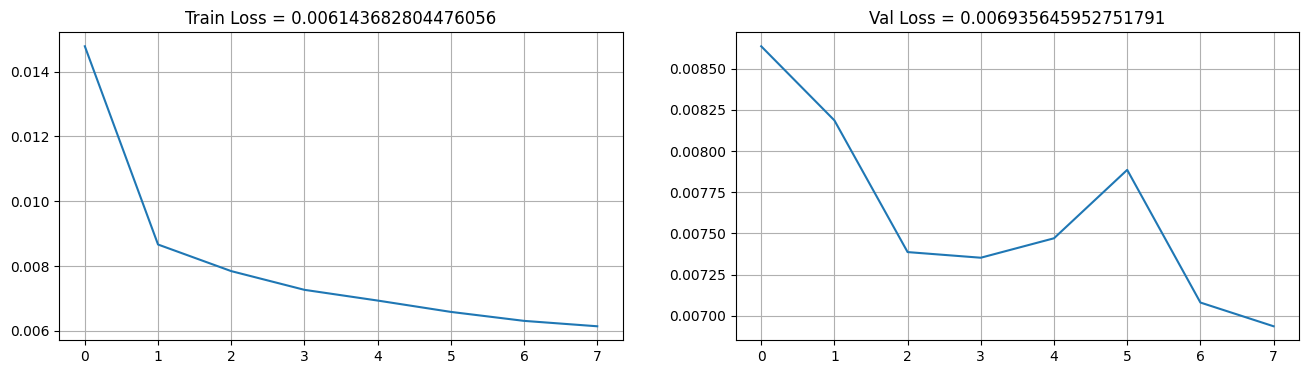

In [ ]:
from torchvision.transforms import ToTensor
from torch.nn import BCEWithLogitsLoss
import torch


dataset = CustomLungDataset(
    root_dir='/kaggle/input/ml-intensive-yandex-autumn-2023/data',
    mode='segmentation',
    transforms=ToTensor()
)

model = Unet(1, 1)
model = model.to(memory_format=torch.channels_last)

optimizer = torch.optim.Adam(model.parameters())
criterion = BCEWithLogitsLoss()

trainer = Trainer(dataset, model, optimizer, criterion, 'segmentation')
trainer.run_train_loop(8, 8)

# Другой вариант модели классификации

In [ ]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model as load

In [ ]:
image_width, image_height = 256, 256
batch_size = 2
num_epochs = 2
model_name = "test_model_1"
data_path = "data"

csv_path = data_path + '/train_answers.csv'
image_folder = data_path + '/train_images'

In [ ]:
labels_df = pd.read_csv(csv_path)
labels_df['path'] = labels_df['id'].apply(lambda x: os.path.join(image_folder, f'img_{x}.png'))
labels_df['target_feature'] = labels_df['target_feature'].astype(str)

In [ ]:
datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=None,  # Since paths are absolute in the DataFrame
    x_col='path',
    y_col='target_feature',
    target_size=(image_width, image_height),
    color_mode='grayscale',  # Specify grayscale color mode
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=None,  # Since paths are absolute in the DataFrame
    x_col='path',
    y_col='target_feature',
    target_size=(image_width, image_height),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation',
    shuffle=True
)

In [ ]:
def save_model(model, model_name):
    model.save(data_path + "/models/" + model_name + '.h5')
    print(f"Model saved as {model_name}.h5")


def load_model(model_name):
    model = load(data_path + "/models/" + model_name + '.h5')
    print(f"Model loaded from {model_name}.h5")
    return model

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(image_width, image_height, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Dense(3, activation='softmax'))

In [ ]:
# ранее обученную модель можно загрузить так:
# model = load_save(model_name)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(),
                                                                          tf.keras.metrics.Recall()])

In [ ]:
history = model.fit(
            train_generator,
            epochs=num_epochs,
            steps_per_epoch=len(train_generator),
            validation_data=validation_generator,
            validation_steps=len(validation_generator)
        )
save_model(model, f"{model_name}_{num_epochs}")

In [ ]:
import pickle

file_name = data_path + "/hist/" + f"{model_name}_hist_{num_epochs}.pkl"
with open(file_name, "wb") as file:
  pickle.dump(history.history, file)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()